In [2]:
import cv2
import numpy as np
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


from utils.dataset import ESC50Dataset
from models.convolutional import CNN2D, CNN1D

C:\Users\davis\anaconda3\envs\venv-aad\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CNN2D.load_from_checkpoint("./runs/epoch=88-val_avg_loss=0.00-val_avg_f1=1.00.ckpt")

CNN2D(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.2, inplace=False)
    (15): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
    (16): AvgPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0)
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [4]:
transforms = [torchaudio.transforms.MelSpectrogram(sample_rate=14700,
                                                  f_min=0,
                                                  n_fft=1024,
                                                  win_length=1024,
                                                  hop_length=512,
                                                  center=False,
                                                  normalized=False,
                                                  mel_scale="slaney",
                                                  n_mels=30,
                                                  power=2),
              torchaudio.transforms.AmplitudeToDB(top_db=80.0)]

dataset = ESC50Dataset("./data/ESC-50-master/meta/esc50_pos.csv", "./data/ESC-50-master/audio/", [1,2,3,4,5], 
                            transforms, 14700, 1, "convolutional", patch_size=4, device="cpu")
dataloader = DataLoader(dataset=dataset, batch_size=1, drop_last=True, num_workers=0)

In [5]:
class CNN2D_CAM(CNN2D):
    def __init__(self, learning_rate=1e-3, weight_decay=5e-4):
        super().__init__(learning_rate, weight_decay)
        
        self.cnn2d = CNN2D.load_from_checkpoint("./runs/epoch=88-val_avg_loss=0.00-val_avg_f1=1.00.ckpt")
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.cnn2d.conv[:13]
        
        # get the max pool of the features stem
        self.avg = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                                       nn.Dropout(p=0.2, inplace=False),
                                       nn.Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1)),
                                       nn.AvgPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0))
        
        self.classifier = self.linear
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.avg(x)
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)


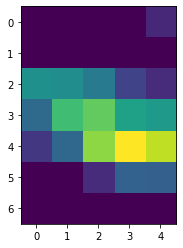

In [365]:
cnn2d = CNN2D_CAM()

cnn2d.eval()

# get the image from the dataloader
spectrogram, label = next(iter(dataloader))

# get the most likely prediction of the model
pred = cnn2d(spectrogram)

# get the gradient of the output with respect to the parameters of the model
pred.backward()

# pull the gradients out of the model
gradients = cnn2d.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = cnn2d.get_activations(spectrogram).detach()

# weight the channels by corresponding gradients
for i in range(64):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

spectrogram = spectrogram.numpy()
heatmap = heatmap.numpy()


plt.imshow(heatmap)

In [366]:
print(f"Predicted {torch.sigmoid(pred).item()>0.5}\nLabel {label.item()==1}")

Predicted False
Label True


[Text(0.5, 0, 'Time [ms]')]

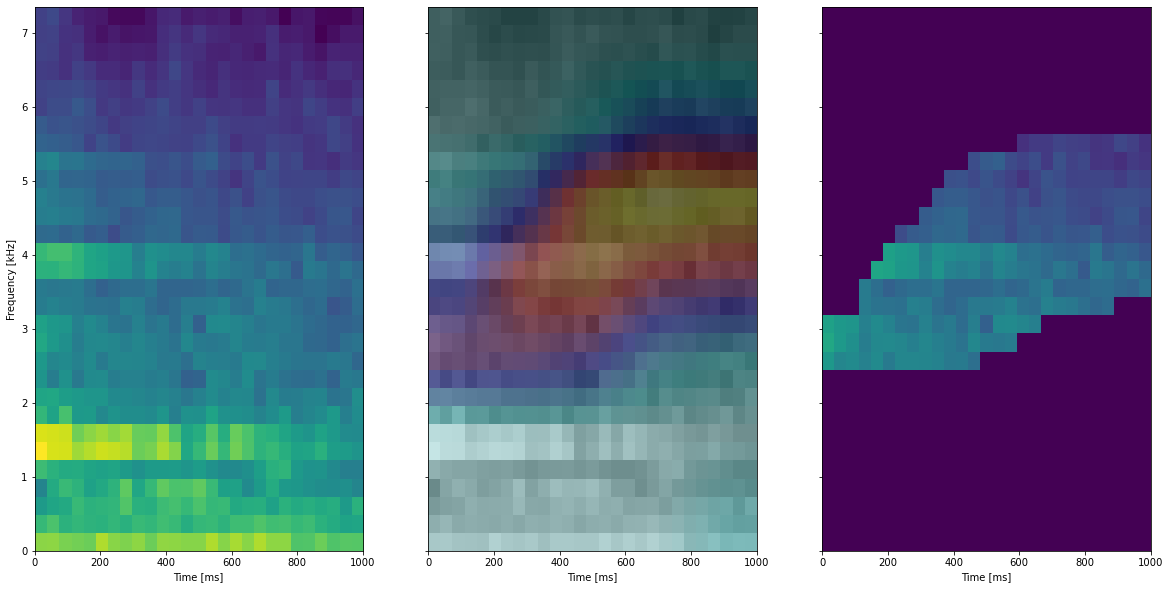

In [367]:
spectrogram_ = np.expand_dims(spectrogram[0,0,:,:], 2)

norm_spectrogram = (spectrogram_ - np.min(spectrogram_)) / (np.max(spectrogram_)  - np.min(spectrogram_))
heatmap_scaled = cv2.resize(heatmap, (norm_spectrogram.shape[1], norm_spectrogram.shape[0]))

heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_scaled), cv2.COLORMAP_JET)
superimposed_spectrogram = (1 - np.float32(heatmap_colored/255))  * 0.25 + norm_spectrogram * 0.65

heatmap_filtered = heatmap_scaled >= 0.4
masked_spectrogram = np.expand_dims(heatmap_filtered, axis=2) * norm_spectrogram

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
ax1.imshow(norm_spectrogram, origin='lower', extent = [0 , 1000, 0, 7.35], aspect='auto')
ax1.set(xlabel='Time [ms]', ylabel='Frequency [kHz]')
ax2.imshow(superimposed_spectrogram, vmin=0, vmax=1, cmap='hot', origin='lower', extent = [0 , 1000, 0, 7.35], aspect='auto')
ax2.set(xlabel='Time [ms]')
ax3.imshow(masked_spectrogram, vmin=0, vmax=1, origin='lower', extent = [0 , 1000, 0, 7.35], aspect='auto')
ax3.set(xlabel='Time [ms]')
